In [1]:
#THIS TRAINS A HYDROLOGICAL MODEL LOCALLY, USING ERA5 AND GLOFAS DATA TO PREDICT GLOFAS DATA
import sys
sys.path.append("../../")

#HYPERPARAMETERS
days_intake_length = 60
forecast_day = 14



In [2]:
#LIBRARY IMPORTS
from functions.floodmodels import shift_input, shift_test_inputs, reshape_scalar_predictand
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster


#Connecting to a cluster to be able to run the code locally/on the cloud
client = Client()
#Use this line of code if you want to run the code on the cluster
# client = Client("tcp://169.45.50.121:8786")



In [3]:
print(client.scheduler_info()['services'])


{'dashboard': 8787}


In [4]:
ds = xr.open_dataset('../../data/features_xy.nc')



In [15]:
#Selecting our X and y values from the dataset. Y has the river discharge values
y_orig = ds['dis']
y = y_orig.copy()
X = ds.drop(['dis', 'dis_diff'])


#Xda, yda = X.to_array(dim='features').T, y
Xda, yda = reshape_scalar_predictand(X, y)


In [6]:
X.to_array(dim='features').T.shape

(13514, 16)

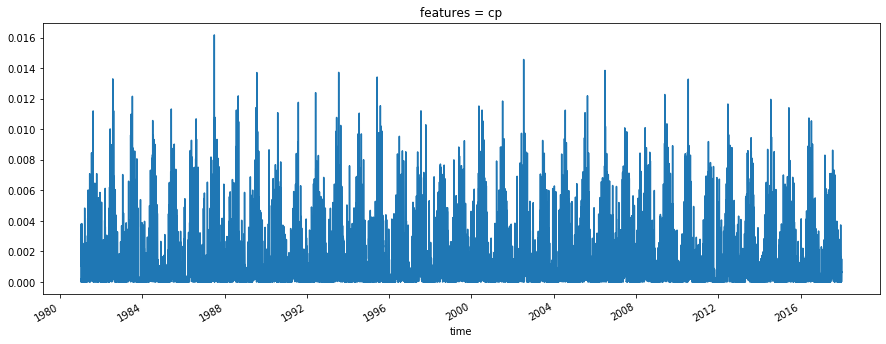

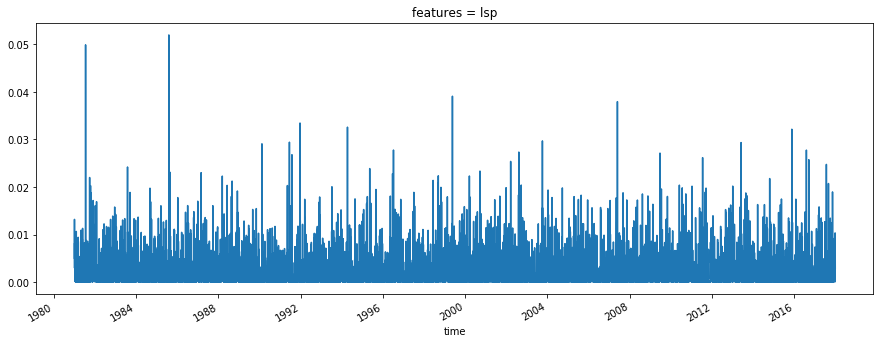

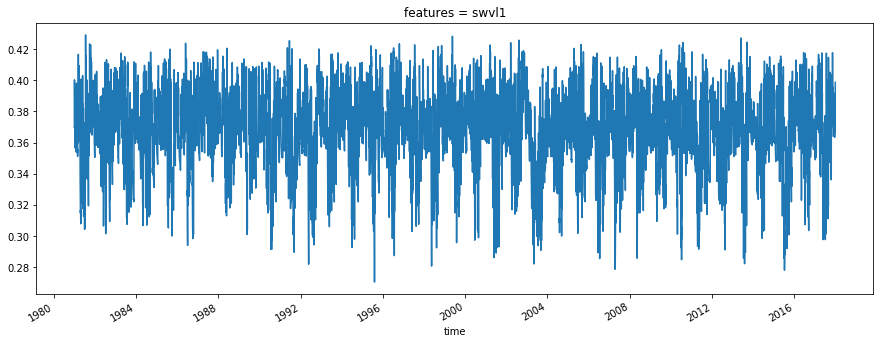

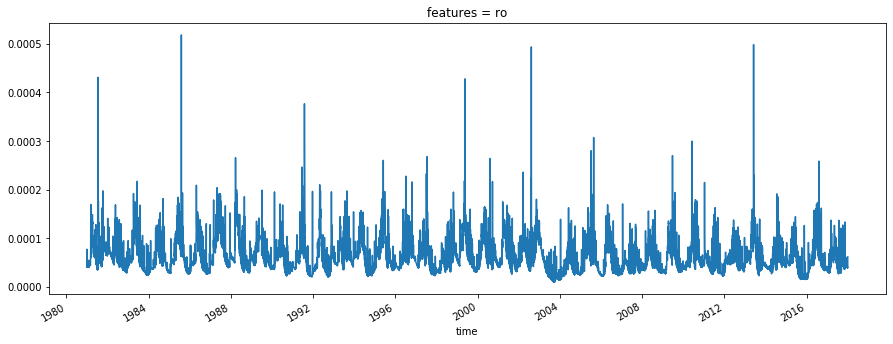

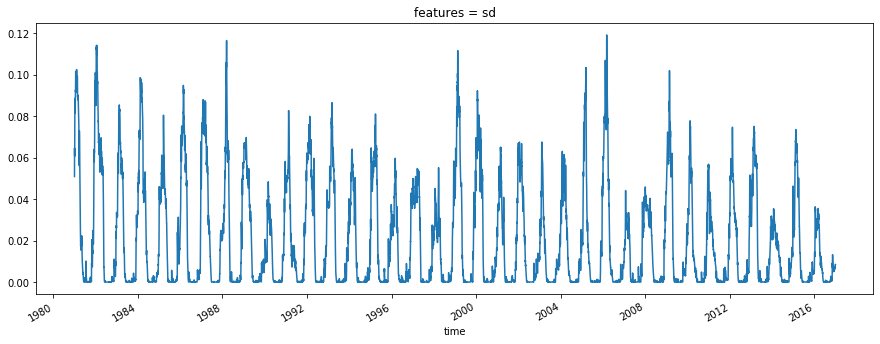

In [52]:
visualization = X.to_array(dim='features').T
for f in visualization.features:
    plt.figure(figsize=(15,5))
    visualization.sel(features=f).plot(ax=plt.gca())
    plt.savefig('../../images/features/' + str(f) + '.png')

In [53]:
yda

<xarray.DataArray (time: 13120)>
array([798.36157227, 792.20770264, 796.70611572, ..., 610.34039307,
       613.92181396, 615.67388916])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2016-12-31

Text(0.5, 1.0, 'Discharge')

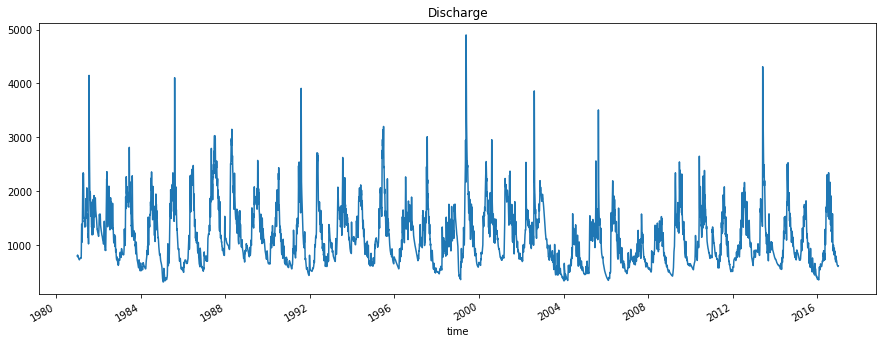

In [54]:
plt.figure(figsize=(15,5))
yda.plot()
plt.title('Discharge')

In [16]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))


X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [17]:
import numpy as np

#Applying feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)
sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(y_train.values.reshape(-1,1))

X_train_final, y_train_final = shift_input(X_train_scaled, y_train_scaled, days_intake_length, 1)

In [18]:
y_train_final = y_train_final.reshape(-1)

In [19]:
y_train_final.shape

(8861,)

In [20]:
#Returns NaN values if you don't choose to use reshape_scalar_predictand

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout


regressor = Sequential()

regressor.add(LSTM(units=800, return_sequences= True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=800, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=800, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=800))
regressor.add(Dropout(0.1))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = regressor.fit(X_train_final, y_train_final, epochs=50, batch_size=32)

Epoch 1/50
1312/8861 [===>..........................] - ETA: 8:33 - loss: 0.0401

In [ ]:
import matplotlib.pyplot as plt
plt.plot(regressor.predict(X_train))

In [ ]:
regressor.predict(X_train)

In [ ]:
regressor_yaml = regressor.to_yaml()
with open("../../models/sample-analysis/final-lstm.yaml", "w") as yaml_file:
    yaml_file.write(regressor_yaml)
# serialize weights to HDF5
regressor.save_weights("../../models/sample-analysis/final-lstm.h5")
#Seialize feature scaling weights

In [ ]:
#LATER ON...LOADING THE MODEL
regressor_model = open('../../sample-analysis/final-lstm.yaml', 'r').read()
from keras.models import model_from_yaml
loaded_regressor = model_from_yaml(regressor_model)
loaded_regressor.load_weights('../../models/sample-analysis/final-lstm.h5')
regressor = loaded_regressor


In [ ]:

#Predicting on validation data
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

#Fitting the test values on the model
X_total = np.concatenate((X_train, X_valid))
#To test our model on the test set, we will need to use part of the training set. More specifically, since our model has been trained on the
#60 previous days, we will need exactly 60 days out of the training set, in addition to all of the test set.
X_inputs = X_total[len(X_total)-len(X_valid)-days_intake_length:]

#Scaling the input data
X_inputs = sc.transform(X_inputs)


y_total = np.concatenate((y_train, y_valid))
y_inputs = y_total[len(y_total)-len(y_valid)-days_intake_length:]

y_inputs = sc2.transform(y_inputs.reshape(-1,1))
#Empty array in which we will append values
X_valid = []
y_valid_feature_array =[]

#Iterating through the 16 features and appending them to X_valid
for n in range(16):
    feature_array = []
    for i in range(days_intake_length, len(X_inputs)):
        #Creates a 2d list with each list inside the list representing a 60 day time interval of the variable
        feature_array.append(X_inputs[i-days_intake_length:i, n])

    #Appending each feature to the final X_valid list
    X_valid.append(feature_array)



for i in range(60, len(X_inputs)):
    y_valid_feature_array.append(y_inputs[i-60:i,0])


X_valid.append(y_valid_feature_array)

X_valid = np.array(X_valid)

#This reshape is necessary since this is the input format the model expects
X_valid = np.reshape(X_valid, (X_valid.shape[1], X_valid.shape[2], X_valid.shape[0]))

y_pred_valid = regressor.predict(X_valid)
# y_pred_valid = sc.inverse_transform(y_pred_valid)
y_pred_valid = sc2.inverse_transform(y_pred_valid)




#Model predicting on test data

#I am calling this again because I will require the original datasets that have not been manipulated in order to apply transformation again
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

#Making the predictions on the test set (where there was a flood event)
X_total = np.concatenate((X_valid, X_test))
#To test our model on the test set, we will need to use part of the training set. More specifically, since our model has been trained on the
#60 previous days, we will need exactly 60 days out of the training set, in addition to all of the test set.
X_inputs = X_total[len(X_total)-len(X_test)-days_intake_length:]

#Scaling the input data
X_inputs = sc.transform(X_inputs)

#Empty array in which we will append values
X_test = []
y_total = np.concatenate((y_valid, y_test))
y_inputs = y_total[len(y_total)-len(y_test)-days_intake_length:]

y_inputs = sc2.transform(y_inputs.reshape(-1,1))
#Empty array in which we will append values
X_test = []
y_test_feature_array =[]

#Iterating through the 16 features and appending them to X_valid
for n in range(16):
    feature_array = []
    for i in range(days_intake_length, len(X_inputs)):
        #Creates a 2d list with each list inside the list representing a 60 day time interval of the variable
        feature_array.append(X_inputs[i-days_intake_length:i, n])

    #Appending each feature to the final X_valid list
    X_test.append(feature_array)

for i in range(60, len(X_inputs)):
    y_test_feature_array.append(y_inputs[i-60:i,0])


X_valid.append(y_valid_feature_array)

X_test = np.array(X_test)

#This reshape is necessary since this is the input format the model expects
X_test = np.reshape(X_test, (X_test.shape[1], X_test.shape[2], X_test.shape[0]))



In [ ]:
y_pred_test = regressor.predict(X_test)

/root/miniconda3/envs/main/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


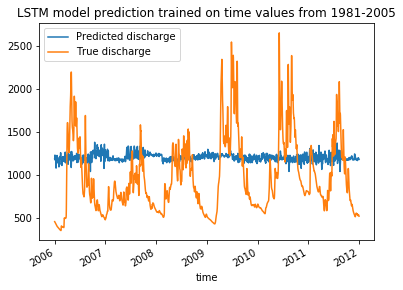

In [12]:
import matplotlib.pyplot as plt

#Plotting the validation predicted values
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
y_pred_valid_xr = xr.DataArray(y_pred_valid.reshape(-1), dims=('time'), coords={'time': X_valid.time.values})
y_pred_valid_xr.plot(label = "Predicted discharge")
#Plotting the real validation values
y_valid_xr = xr.DataArray(y_valid, dims=('time'), coords={'time': X_valid.time.values})
y_valid_xr.plot(label="True discharge")
plt.title('LSTM model prediction trained on time values from 1981-2005')
plt.legend(loc='upper left')